episode 0 win pct 0.00 epsilon 1.00
episode 100 win pct 0.67 epsilon 0.02
episode 200 win pct 1.00 epsilon 0.01
episode 300 win pct 0.99 epsilon 0.01
episode 400 win pct 0.95 epsilon 0.01
episode 500 win pct 1.00 epsilon 0.01
episode 600 win pct 0.98 epsilon 0.01
episode 700 win pct 0.99 epsilon 0.01
episode 800 win pct 1.00 epsilon 0.01
episode 900 win pct 0.98 epsilon 0.01
episode 1000 win pct 0.99 epsilon 0.01
episode 1100 win pct 1.00 epsilon 0.01
episode 1200 win pct 0.99 epsilon 0.01
episode 1300 win pct 0.99 epsilon 0.01
episode 1400 win pct 0.98 epsilon 0.01
episode 1500 win pct 0.99 epsilon 0.01
episode 1600 win pct 0.98 epsilon 0.01
episode 1700 win pct 1.00 epsilon 0.01
episode 1800 win pct 0.96 epsilon 0.01
episode 1900 win pct 0.98 epsilon 0.01
episode 2000 win pct 1.00 epsilon 0.01
episode 2100 win pct 1.00 epsilon 0.01
episode 2200 win pct 0.97 epsilon 0.01
episode 2300 win pct 0.98 epsilon 0.01
episode 2400 win pct 0.99 epsilon 0.01


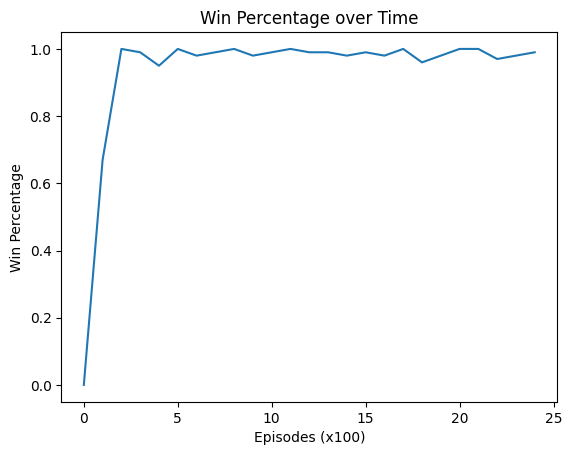

In [4]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt

# Neural Network for approximating Q-values
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Deep Q-Learning Agent
class DQNAgent:
    def __init__(self, env, learning_rate=0.001, discount_factor=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995, buffer_size=10000, batch_size=64):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.buffer_size = buffer_size
        self.batch_size = batch_size

        self.memory = deque(maxlen=buffer_size)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.q_network = QNetwork(env.observation_space.n, env.action_space.n).to(self.device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.criterion = nn.MSELoss()

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()  # Explore
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
            with torch.no_grad():
                q_values = self.q_network(state_tensor)
            return torch.argmax(q_values).item()  # Exploit

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert lists of numpy arrays to a single numpy array
        #states = np.array(states)
        #actions = np.array(actions)
        #rewards = np.array(rewards)
        #next_states = np.array(next_states)
        #dones = np.array(dones)

        states_tensor = torch.tensor(states, dtype=torch.float32).to(self.device)
        actions_tensor = torch.tensor(actions, dtype=torch.int64).unsqueeze(-1).to(self.device)
        rewards_tensor = torch.tensor(rewards, dtype=torch.float32).unsqueeze(-1).to(self.device)
        next_states_tensor = torch.tensor(next_states, dtype=torch.float32).to(self.device)
        dones_tensor = torch.tensor(dones, dtype=torch.float32).unsqueeze(-1).to(self.device)

        current_q_values = self.q_network(states_tensor).gather(1, actions_tensor)
        next_q_values = self.q_network(next_states_tensor).max(1)[0].unsqueeze(-1)
        target_q_values = rewards_tensor + self.discount_factor * next_q_values * (1 - dones_tensor)

        loss = self.criterion(current_q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

# Function to one-hot encode state
def one_hot_encode(state, state_space):
    one_hot = np.zeros(state_space)
    one_hot[state] = 1
    return one_hot

# Create the environment
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False)

# Instantiate the agent
agent = DQNAgent(env)

n_episodes = 2500
win_pct_list = []
scores = []

# Training loop
for i in range(n_episodes):
    state, info = agent.env.reset()  # Reset the environment
    state = one_hot_encode(state, env.observation_space.n)
    done = False
    score = 0
    while not done:
        action = agent.choose_action(state)  # Choose action based on epsilon-greedy policy
        next_state, reward, done, truncated, info = agent.env.step(action)  # Take the action
        next_state = one_hot_encode(next_state, env.observation_space.n)
        agent.store_transition(state, action, reward, next_state, done)
        agent.learn()  # Update Q-network
        state = next_state  # Move to the next state
        score += reward
    scores.append(score)
    if i % 100 == 0:
        avg_score = np.mean(scores[-100:])
        win_pct_list.append(avg_score)
        print('episode', i, 'win pct %.2f' % avg_score, 'epsilon %.2f' % agent.epsilon)

# Plotting the win percentage over episodes
plt.plot(win_pct_list)
plt.xlabel('Episodes (x100)')
plt.ylabel('Win Percentage')
plt.title('Win Percentage over Time')
plt.show()
